In [3]:
!pip install kaggle

!mkdir -p ~/.kaggle

from google.colab import files
files.upload()

!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download ambarish/breakhis
!unzip breakhis.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-026.png  
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-027.png  
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-028.png  
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-029.png  
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC-14-12312-40-030.png  
  inflating: /content/dataset/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma/SOB_M_DC_14-12312/40X/SOB_M_DC

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split

csv_file = '/content/dataset/Folds.csv'

try:
    df = pd.read_csv(csv_file)

    print("Columns in the DataFrame:")
    print(df.columns)

    if 'filename' in df.columns and 'grp' in df.columns:
        filenames = df['filename'].tolist()
        labels = df['grp'].tolist()

        # Split data into train and validation sets
        train_filenames, val_filenames, train_labels, val_labels = train_test_split(
            filenames, labels, test_size=0.2, random_state=42)

        # Print some stats
        print(f'Total images: {len(filenames)}')
        print(f'Training images: {len(train_filenames)}')
        print(f'Validation images: {len(val_filenames)}')

    else:
        print("Required columns 'filename' and 'grp' not found in the DataFrame. Check your CSV file structure.")

except FileNotFoundError:
    print(f'File not found at path: {csv_file}. Please check the file path and try again.')

except KeyError as e:
    print(f'KeyError: {e}. Please check the column names in your CSV file and adjust the code accordingly.')


Columns in the DataFrame:
Index(['fold', 'mag', 'grp', 'filename'], dtype='object')
Total images: 39545
Training images: 31636
Validation images: 7909


In [6]:
import pandas as pd

csv_file = '/content/dataset/Folds.csv'
df = pd.read_csv(csv_file)

print(df.head())


   fold  mag    grp                                           filename
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
import os
import shutil

base_dir = '/content/dataset/BreaKHis_v1'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

unique_labels = df['grp'].unique()

for label in unique_labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(val_dir, label), exist_ok=True)


In [8]:
for index, row in df.iterrows():
    filepath = row['filename']
    label = row['grp']
    fold = row['fold']

    src_file = os.path.join(base_dir, filepath)
    if fold == 1:
        dst_dir = os.path.join(train_dir, label)
    else:
        dst_dir = os.path.join(val_dir, label)

    shutil.copy(src_file, dst_dir)


In [9]:
import tensorflow as tf

img_height, img_width = 150, 150
batch_size = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='/content/dataset/BreaKHis_v1/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    directory='/content/dataset/BreaKHis_v1/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 7909 images belonging to 2 classes.
Found 14468 images belonging to 2 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [11]:
loss, accuracy = model.evaluate(val_generator, verbose=1)
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')


453/453 [==============================] - 447s 986ms/step - loss: 0.6912 - accuracy: 0.5422
Validation loss: 0.6912
Validation accuracy: 0.5422


In [12]:
model.save('/content/brest_cancer_detection_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(val_generator)
y_pred_binary = (y_pred > 0.5).astype(int)

y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_binary)
print("Confusion Matrix:")
print(cm)

453/453 [==============================] - 458s 1s/step
Confusion Matrix:
[[   0 6623]
 [   0 7845]]


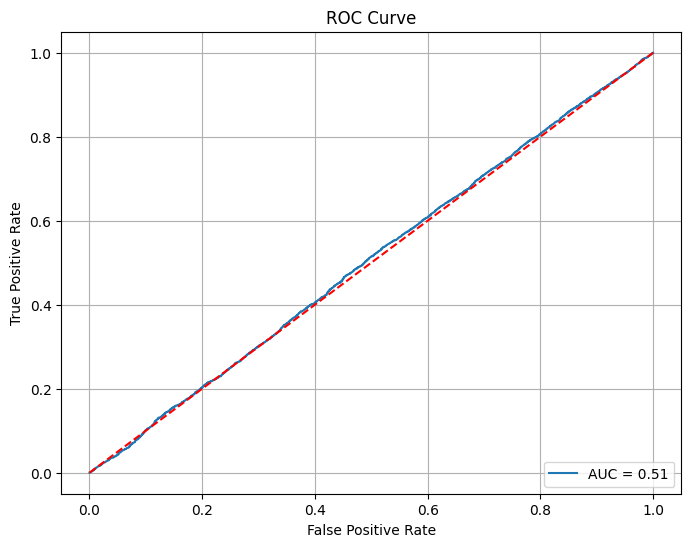

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf

img_height, img_width = 224, 224
batch_size = 32

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory='/content/dataset/BreaKHis_v1/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    directory='/content/dataset/BreaKHis_v1/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in base_model.layers:
    layer.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)


Found 7909 images belonging to 2 classes.
Found 14468 images belonging to 2 classes.
Epoch 1/10
247/247 [==============================] - 512s 2s/step - loss: 0.6717 - accuracy: 0.6224 - val_loss: 0.6971 - val_accuracy: 0.5422
Epoch 2/10
247/247 [==============================] - 513s 2s/step - loss: 0.6617 - accuracy: 0.6332 - val_loss: 0.6950 - val_accuracy: 0.5422
Epoch 3/10
247/247 [==============================] - 525s 2s/step - loss: 0.6624 - accuracy: 0.6331 - val_loss: 0.7059 - val_accuracy: 0.5422
Epoch 4/10
247/247 [==============================] - 504s 2s/step - loss: 0.6610 - accuracy: 0.6332 - val_loss: 0.7009 - val_accuracy: 0.5422
Epoch 5/10
247/247 [==============================] - 504s 2s/step - loss: 0.6604 - accuracy: 0.6326 - val_loss: 0.7017 - val_accuracy: 0.5423


In [ ]:
model.save('/content/cancer_detection.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

img_height, img_width = 224, 224
batch_size = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/dataset/BreaKHis_v1/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/dataset/BreaKHis_v1/val',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping]
)
loss, accuracy = model.evaluate(val_generator, steps=val_generator.samples // batch_size)
print(f'Validation loss: {loss:.4f}')
print(f'Validation accuracy: {accuracy:.4f}')


Found 7909 images belonging to 2 classes.
Found 14468 images belonging to 2 classes.
Epoch 1/10
247/247 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.6235